# Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# Sample data
data = pd.read_csv('Houseprice.csv')
data

,Date,Region ID,Region Name,Region Type,State Name,Home Value Index,Size Rank
0,7/31/03,395162,"Torrington, CT",msa,CT,206829.9543,236
1,8/31/03,395162,"Torrington, CT",msa,CT,209576.4668,236
2,9/30/03,395162,"Torrington, CT",msa,CT,212398.5270,236
3,10/31/03,395162,"Torrington, CT",msa,CT,215175.9703,236
4,11/30/03,395162,"Torrington, CT",msa,CT,217573.4558,236
...,...,...,...,...,...,...,...
255965,3/31/17,394776,"Laurel, MS",msa,MS,107746.9037,434
255966,3/31/17,395124,"Starkville, MS",msa,MS,169984.2309,529
255967,3/31/17,394490,"Columbus, MS",msa,MS,125443.1976,543
255968,3/31/17,394977,"Picayune, MS",msa,MS,150324.7686,559


# Loading and Preprocessing Data

In [2]:
data = data[data['Region Name'] == 'Salt Lake City, UT']
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
df = pd.DataFrame(data)
df

,Date,Region ID,Region Name,Region Type,State Name,Home Value Index,Size Rank
163600,2000-01-31,395053,"Salt Lake City, UT",msa,UT,173370.8057,48
163605,2000-02-29,395053,"Salt Lake City, UT",msa,UT,173473.7350,48
163610,2000-03-31,395053,"Salt Lake City, UT",msa,UT,173659.8637,48
163615,2000-04-30,395053,"Salt Lake City, UT",msa,UT,174086.9221,48
163620,2000-05-31,395053,"Salt Lake City, UT",msa,UT,175910.0283,48
...,...,...,...,...,...,...,...
165005,2023-06-30,395053,"Salt Lake City, UT",msa,UT,524735.4525,48
165010,2023-07-31,395053,"Salt Lake City, UT",msa,UT,526616.8991,48
165015,2023-08-31,395053,"Salt Lake City, UT",msa,UT,528841.3976,48
165020,2023-09-30,395053,"Salt Lake City, UT",msa,UT,530407.2567,48


# Data Exploration and Preparation

In [3]:
df = df[['Date', 'Home Value Index']]
df

,Date,Home Value Index
163600,2000-01-31,173370.8057
163605,2000-02-29,173473.7350
163610,2000-03-31,173659.8637
163615,2000-04-30,174086.9221
163620,2000-05-31,175910.0283
...,...,...
165005,2023-06-30,524735.4525
165010,2023-07-31,526616.8991
165015,2023-08-31,528841.3976
165020,2023-09-30,530407.2567


# Data Normalization and Train-Test Split

In [4]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Function to create dataset for RNN
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [5]:
# Define look_back period
look_back = 3
X, Y = create_dataset(scaled_data, look_back)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:,:], X[train_size:len(X),:,:]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Creating RNN Model


In [6]:
#  Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0494
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0064
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4093e-04 - val_loss: 0.0078
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7604e-04 - val_loss: 0.0012
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8633e-05 - val_loss: 6.4046e-04
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.6066e-05 - val_loss: 7.5753e-04
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5845e-05 - val_loss: 6.6978e-04
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9745e-05 - val_loss: 6.2127e-04
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8026e-05 - v

In [7]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 957us/step


# Making Predictions and Evaluating the Model


In [8]:
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform([Y_test])

In [9]:
# Calculate root mean squared error
train_rmse = np.sqrt(np.mean((train_predict[:,0] - Y_train_inv[0])**2))
test_rmse = np.sqrt(np.mean((test_predict[:,0] - Y_test_inv[0])**2))

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 2143.3874432187417
Test RMSE: 7300.0539709336645


In [10]:
# Assuming your train and test sets are split correctly
# Adjusting indices to match the length of the predictions

train_predict_length = len(train_predict)
test_predict_length = len(test_predict)

# Calculate the correct starting and ending indices
train_index_start = look_back
train_index_end = train_index_start + train_predict_length

test_index_start = train_size + look_back
test_index_end = test_index_start + test_predict_length

# Creating DataFrames with correct indices
train_predict_df = pd.DataFrame(train_predict, index=df.index[train_index_start:train_index_end], columns=['Predicted'])
train_actual_df = pd.DataFrame(Y_train_inv.T, index=df.index[train_index_start:train_index_end], columns=['Actual'])

test_predict_df = pd.DataFrame(test_predict, index=df.index[test_index_start:test_index_end], columns=['Predicted'])
test_actual_df = pd.DataFrame(Y_test_inv.T, index=df.index[test_index_start:test_index_end], columns=['Actual'])


# Visualizing Training Results


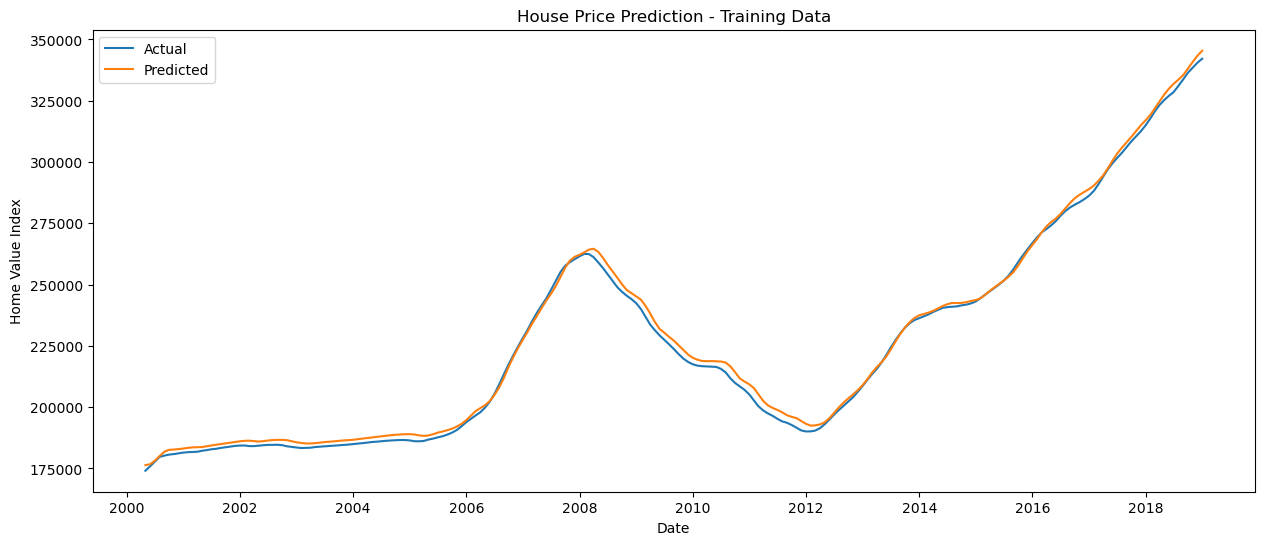

In [11]:
# Plotting Train Data
plt.figure(figsize=(15, 6))
plt.plot(train_actual_df, label='Actual')
plt.plot(train_predict_df, label='Predicted')
plt.title('House Price Prediction - Training Data')
plt.xlabel('Date')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()

# Visualizing Testing Results


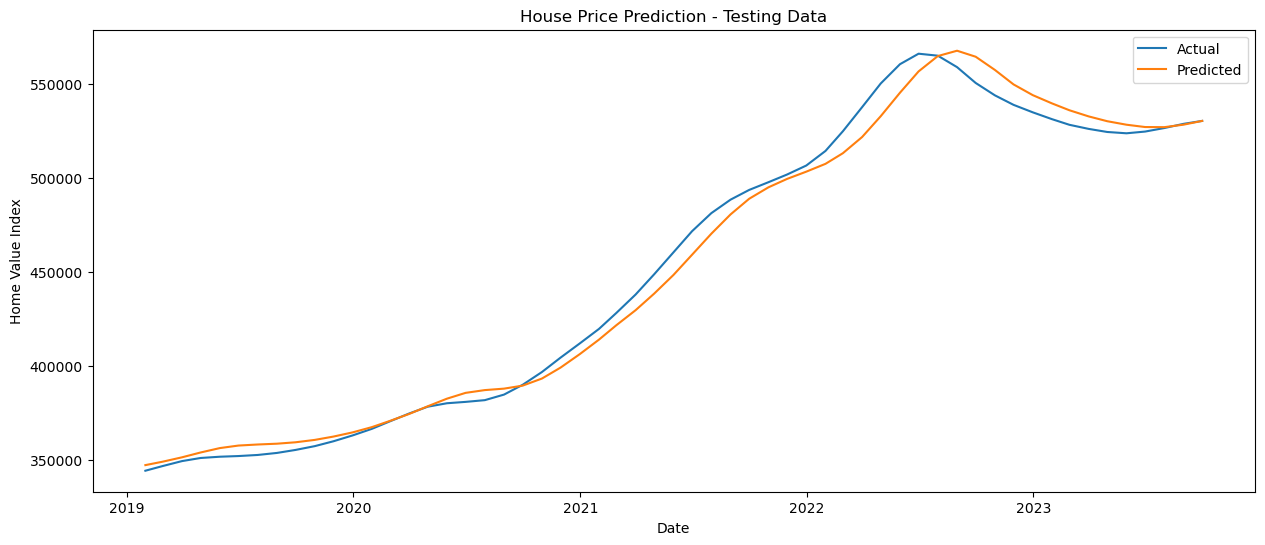

In [12]:
# Plotting Test Data
plt.figure(figsize=(15, 6))
plt.plot(test_actual_df, label='Actual')
plt.plot(test_predict_df, label='Predicted')
plt.title('House Price Prediction - Testing Data')
plt.xlabel('Date')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()

# Generating Future Predictions


In [13]:
# Future Predictions
future_months = 24
future_predictions = []
current_input = scaled_data[-look_back:]  # Start with the last known data

for _ in range(future_months):
    # Reshape input for the model
    reshaped_input = current_input.reshape((1, look_back, 1))
    
    # Predict the next step
    next_prediction = model.predict(reshaped_input)

    # Append the prediction to the list
    future_predictions.append(next_prediction[0, 0])
    
    # Update the input sequence
    next_prediction_reshaped = np.array([next_prediction[0, 0]]).reshape(1, -1)
    current_input = np.append(current_input[1:], next_prediction_reshaped, axis=0)

# Inverse transform to get actual value predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Adjust the date generation to reflect monthly steps
last_date = df.index[-1]
prediction_dates = pd.date_range(start=last_date, periods=future_months, freq='MS')
future_df = pd.DataFrame(future_predictions, index=prediction_dates, columns=['Predicted Future Value'])

1/1 [==============================] - 0s 7ms/step


# Visualizing Test Data and Future Predictions

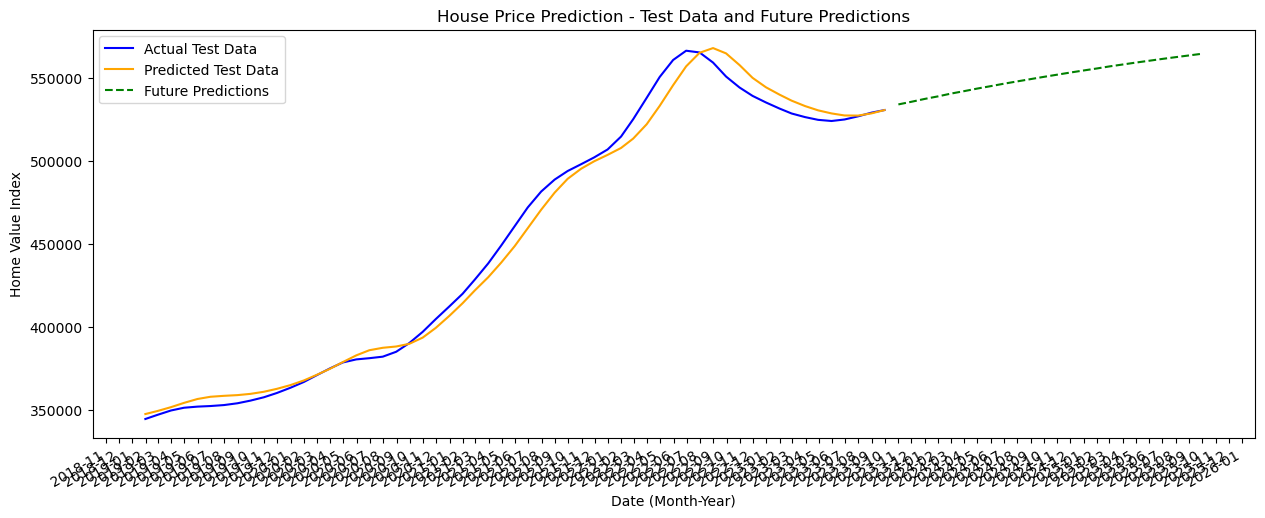

In [14]:
# Plotting Test Data and Future Predictions
plt.figure(figsize=(15, 6))

# Plot actual and predicted test data
plt.plot(test_actual_df, label='Actual Test Data', color='blue')
plt.plot(test_predict_df, label='Predicted Test Data', color='orange')

# Plot future predictions
plt.plot(future_df, label='Future Predictions', color='green', linestyle='dashed')

# Formatting the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotate date labels

plt.title('House Price Prediction - Test Data and Future Predictions')
plt.xlabel('Date (Month-Year)')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()
